# Тесты с генетическим алгоритмом (Скрещивание)

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [43]:
def print_NRS_graph(model):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        plt.show()

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model):
    '''
    Построение графа НРС
    '''
    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nx.draw(G, with_labels=True)
    plt.show()

    return G
# from workFolder.nrs import q_out_simple

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'НРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)
            
        return super().appendElement(elmnt)

    def crossing(self, pair_model):
        return self

    def mutate(self, mutation_count=1):
        '''
        Мутация элементов модели
        '''
        for _ in range(mutation_count):
            random.choice(self.elmnts).mutate()


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > self.H_max:
            self.H_add = self.H_max
        else:
            self.H_add = H_add
        if H_add <= self.H_min:
            self.H_add = self.H_min
        else:
            self.H_add = H_add

    def mutate(self):
        mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.H_add+=change_val
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)




class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-5,5)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества выходов
        change_val = random.choice([2,3,4,5])
        # if change_val < self.ro:
        #     print('Удаляется', self.name)
        self.set_ro(change_val)

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        change_val = random.choice([2,3,4,5])
        self.set_ri(change_val)

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)


# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }



#=====================================Оценщик=====================================================================================================
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)





#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()


#==============================================Рекурсии=========================================================================
# Рекурсивное построение дерева
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)


def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model

# Пресеты

Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м


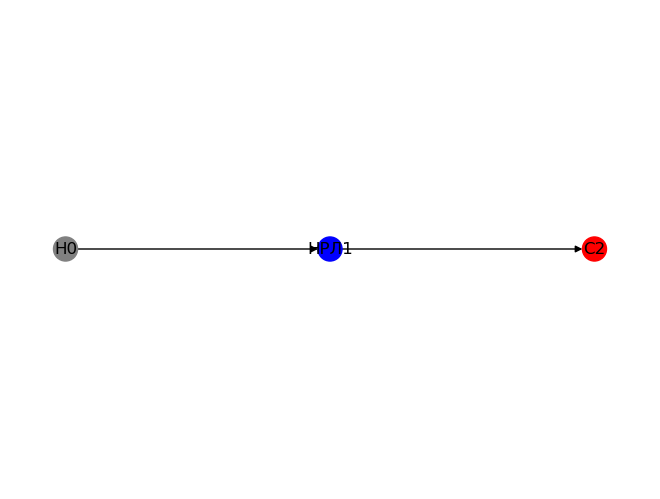

In [3]:
class Presets():

    @staticmethod
    def single_line():
        '''
        Простая НРС с одной РРЛ и одним стволом

            |=|>-------------|->
        '''
        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)

        pump.append(hose).append(nozzle)

        model = GA_model('Простая НРС с одной РРЛ и одним стволом')
        model.addElements([pump,hose,nozzle])
        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_splitter(nozzles_count=2):
        '''
        Сложная НРС с одним разветвлением и nozzles_count рабочих линий

                             ------|->
            |=|>------{------|->
                             ------|->
            
        '''
        if not nozzles_count in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с одним разветвлением и nozzles_count рабочих линий')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM).append(spliiter)

        model.addElements([pump,hoseM,spliiter])

        for _ in range(nozzles_count):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def two_splitter(nozzles_count1=2, nozzles_count2=2):
        '''
        Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка

                             ------|->          ------|->
            |=|>------{------------------{------|->
                             ------|->          ------|->
            
        '''
        if not nozzles_count1 in [1,2]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 2!")
        if not nozzles_count2 in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter1 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter2 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM1).append(spliiter1).append(hoseM2).append(spliiter2)

        model.addElements([pump,hoseM1,spliiter1,hoseM2,spliiter2])

        for _ in range(nozzles_count1):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter1.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        for _ in range(nozzles_count2):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter2.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        
        return model.check_pumps().interpretate()

    @staticmethod
    def single_joiner(nozzle_q=20, nozzle_workpress=60):
        '''
        Сложная НРС с одним водосборником и лафетным стволом

            |=|>------
                             }------|-,->
            |=|>------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        pump2 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner)
        pump2.append(hoseM2).append(joiner)
        joiner.append(hoseW1).append(nozzle)

        model.addElements([pump1,hoseM1,pump2,hoseM2,joiner,hoseW1,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def n_components(n=2):
        '''
        Простая НРС из n компонентов в виде простых НРС

            n * |=|>-------------|->
            
        '''
        model = GA_model(f'Простая НРС из {n} компонентов в виде простых НРС')

        for _ in range(n):
            for e in Presets.single_line().elmnts:
                e.name=''
                model.addElements([e])

        return model.check_pumps().interpretate()


model = Presets.single_line()
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


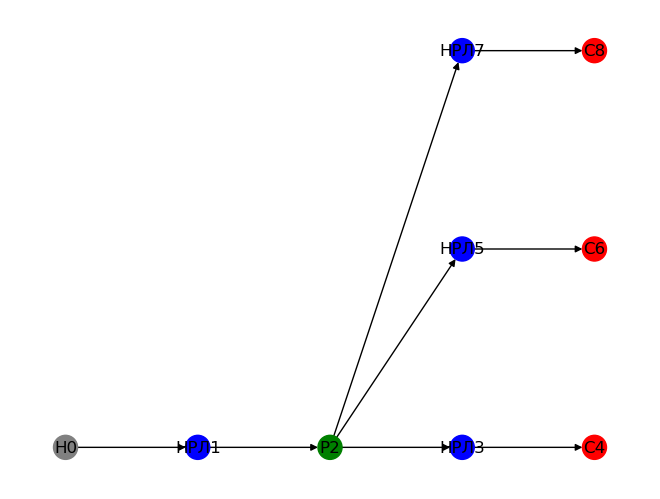

In [4]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка
Расстояние до Н0 120 м


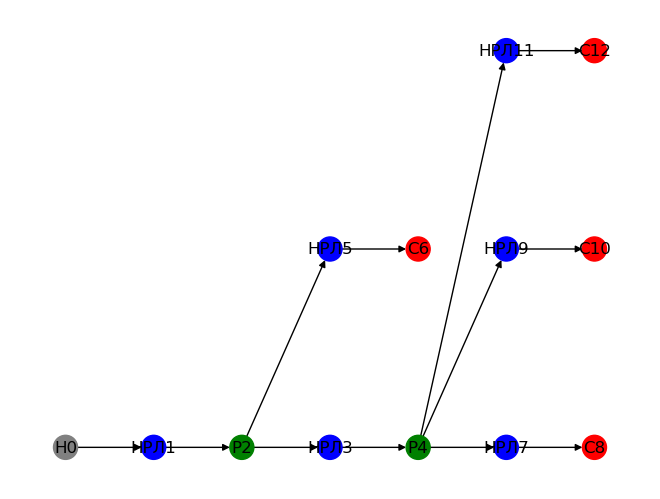

In [5]:
model = Presets.two_splitter(nozzles_count1=1, nozzles_count2=3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Расстояние до Н0 80 м
Расстояние до Н2 80 м


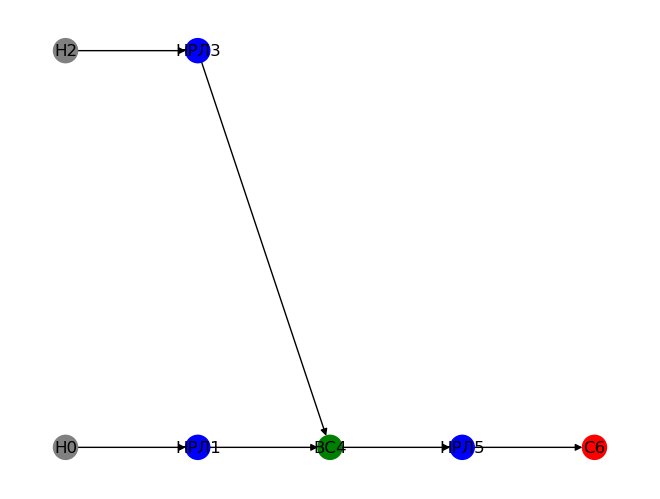

In [6]:
model = Presets.single_joiner(30)
print_NRS_graph(model)

Новая модель: Простая НРС из 3 компонентов в виде простых НРС
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м
Расстояние до Н3 40 м
Расстояние до Н6 40 м


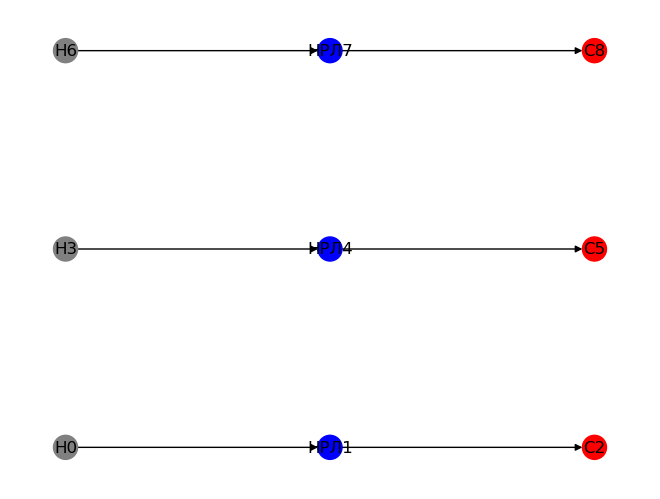

In [7]:
model = Presets.n_components(3)
print_NRS_graph(model)

In [8]:
# Расчет
try:
    model.calc(accuracy=0.05)
except Exception as e:
    print(e.args[0])
print(f'Общий расход системы: {model.summaryQ()} л/с', end='\n\n')

# Состав
NRS_Revision.print_model_elements(model)
Appraiser.print_GA_NRS_model_elements_state(model)

Общий расход системы: 10.640572147070957 л/с

all:
  Н0
  НРЛ1
  С2
  Н3
  НРЛ4
  С5
  Н6
  НРЛ7
  С8
in:
  Н0
  Н3
  Н6
out:
  С2
  С5
  С8
Насос (Н0); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н3); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н6); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ4), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м

Ствол (С2): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С5): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 36.

# Тесты

In [9]:
# p_nozzleB = NRS_Revision.calc_p(3.7, 40)
# p_nozzleA = NRS_Revision.calc_p(7.4, 40)
# p_nozzleL = NRS_Revision.calc_p(16, 40)
# p_nozzleB, p_nozzleA, p_nozzleL

# Мутации

## Тест макромутаций

Макромутации - мутации в структуре модели. Добавление, изменение и удаление элементов модели.

## Тест корректного удаления элементов

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


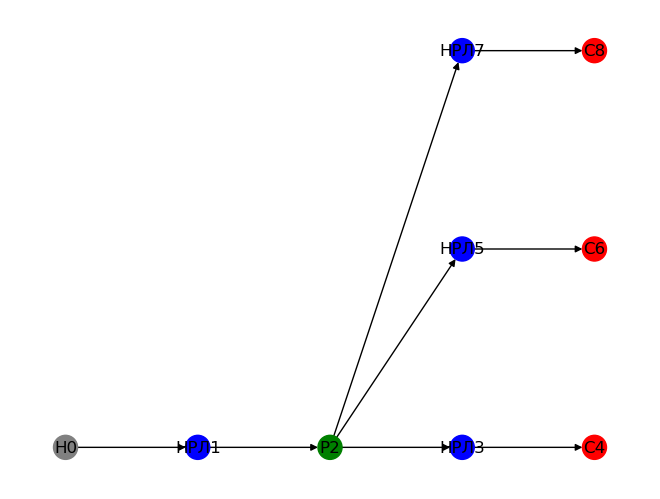

In [10]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


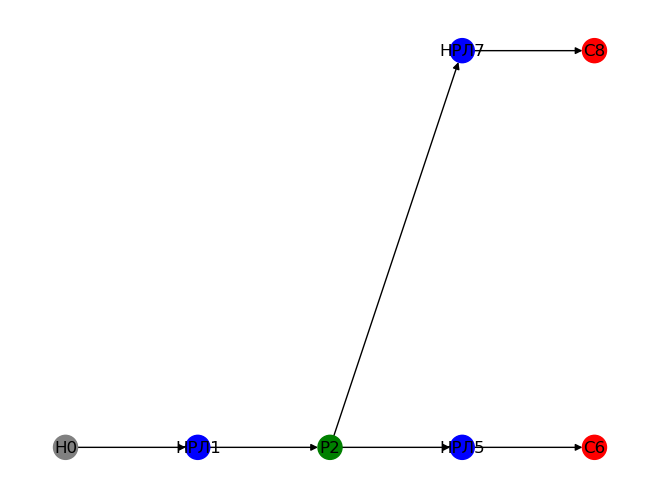

In [11]:
model = Presets.single_splitter(3)
model.getElement('Р2').set_ro(2)
for e in model.elmnts:
    model.fire_dead_elements_try(e)
print_NRS_graph(model)

### Проверка обучения

С удалением ветвей

In [59]:
model = Presets.single_splitter(3)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий


In [60]:
aims = {'Q':15, '38дв':0, '51нп':0, '89':0,'110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}

curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
for i in range(2000):
    print(f'{i}\t', end='\r')
    model_back = copy.deepcopy(model)
    to_print = i%100==0
    try:
        model.mutate(mutation_count=2)
        for elmnt in model.elmnts:
            model.fire_dead_elements_try(elmnt)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
        if newQ>curQ:
            model = model_back
        if newQ<curQ:
        # if to_print:
            curQ=newQ
            print(i, newQ, model.summaryQ(), sep='\t')
    except:
        # print(i, 'Модель не жизнеспособна')
        model = model_back

print('Итог:', curQ, model.summaryQ(), sep='\t')

1	0.7155945473060672	10.314327161635969
2	0.6920002722331479	10.229983666011126
3	0.592106675056075	10.105199622476627
4	0.4787537927323835	9.20607932704274
5	0.4613825571650838	9.987784927571226
7	0.44937667295537076	10.528049717008315
8	0.4187880356015621	10.404538397929707
14	0.3624541480319601	9.939563338561799
16	0.31924445130499923	11.883999691275035
38	0.2962337026268653	12.91948338179106
53	0.29041940329749744	13.181126851612616
62	0.2773947113088758	13.767237991100592
77	0.2541133822193237	13.314897800130433
85	0.24203144403446744	13.858585018448965
87	0.21422820256664177	14.359730884501122
101	0.20648944169645522	15.297822991151305
111	0.20284020393605326	15.128907548300607
127	0.19053954248727845	14.67572058807247
170	0.18678649800946798	15.15701904831947
202	0.18549868627059374	15.098078002650075
259	0.1680770569631338	12.686532436658979
274	0.16742498910494094	12.715875490277657
275	0.1587283457299026	13.107224442154383
278	0.15028394040336182	13.487222681848717
293	0.1402

Насос (Н0); напор: 125 м; производительность: 15.028923835013302 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 280 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 44.87742651011741 м
Рукавная линия (НРЛ3), длина: 120 м; диаметр: 66нп мм; сопротивление 0.077; потеря напора: 10.349820446379507 м
Рукавная линия (НРЛ5), длина: 120 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 4.983831994642598 м
Рукавная линия (НРЛ7), длина: 120 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 4.983831994642598 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 69.77275304350309, м; расход: 4.886688523851191, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 75.13874149524, м; расход: 5.071117655581054, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 75.13874149524, м; расход: 5.071117655581054, л/с
hoses	32
nozzles	3
distances	{'Н0': {'С4': 400, 'С6': 400, 'С8': 400}}
min_L	400
max_L	400
77	14
66нп	6
Б	3
66	12
Q	15.0289238350133
Расстояние д

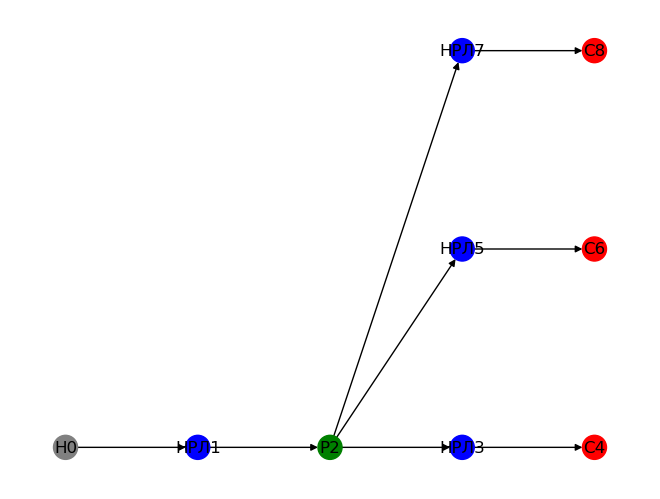

In [61]:
Appraiser.print_GA_NRS_model_elements_state(model)
print('='*80)
Appraiser.print_metrics(model)
print_NRS_graph(model)